In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import os
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ

import ramsey_experiment

# Loading your IBM Quantum account(s)
IBMQ.save_account(os.environ.get('IBM_KEY'), overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')



ibmqfactory.load_account:WARNING:2024-02-11 11:18:46,787: Credentials are already in use. The existing account in the session will be replaced.


In [2]:
import Ramsey_ExperimentV2
import random
import importlib
from tqdm import tqdm

ramsey_experiment = importlib.reload(Ramsey_ExperimentV2)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[(i + 1) % n] - 1) for i in range(n - 1)])
y_lornz = lambda a, x, w: np.pi * (2 * a / (a ** 2 + (x - w) ** 2) + 2 * a / (a ** 2 + (x + w) ** 2))
y_lornz_single = lambda a, x, w: (2 * a / ((a ** 2 + x ** 2) * 2 * np.pi))


def sinc(x_values):
    X = []
    for x in x_values:
        X.append((np.sin(2 * x * np.pi) / (2 * x * np.pi) if x != 0 else 1))
    return X


def fisher_inf(x, w, a):
    cos_wx_squared = np.cos(w * x) ** 2
    sin_wx_squared = np.sin(w * x) ** 2
    exp_ax = np.exp(a * x)

    term1 = x ** 2 * cos_wx_squared / (exp_ax + np.cos(w * x)) ** 2
    term2 = x ** 2 * sin_wx_squared / (exp_ax + np.cos(w * x)) ** 2

    return term1 + term2


def effective_hem(size, J, W):
    hem = np.zeros((2 ** size, 2 ** size))
    for i in range(2 ** size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1) ** int(i) for i in binary]
        #Z.reverse()
        hem[i, i] = h(size, J, Z)
        hem[i, i] += sum([W[k] for k in range(size) if binary[k] == '1'])
    return hem

In [3]:
import numpy as np


def p(t, w, a):
    return 1 / 2 * (1 + np.cos(w * t) * np.exp(-a * t))


def pw(t, w, a):
    return - 1 / 2 * t * np.sin(w * t) * np.exp(-a * t)


def pww(t, w, a):
    return - 1 / 2 * t ** 2 * np.cos(w * t) * np.exp(-a * t)


def pa(t, w, a):
    return - 1 / 2 * t * np.cos(w * t) * np.exp(-a * t)


def paa(t, w, a):
    return 1 / 2 * t ** 2 * np.cos(w * t) * np.exp(-a * t)


def paw(t, w, a):
    return 1 / 2 * t ** 2 * np.sin(w * t) * np.exp(-a * t)


def fisher_matrix(t, w, a, shots):
    Iww = 0
    Iaa = 0
    Iwa = 0

    for i in range(len(t)):
        p0 = p(t[i], w, a)
        p1 = 1 - p0
        pw0 = pw(t[i], w, a)
        pw1 = -pw0
        pww0 = pww(t[i], w, a)
        pww1 = -pww0
        pa0 = pa(t[i], w, a)
        pa1 = -pa0
        paa0 = paa(t[i], w, a)
        paa1 = -paa0
        paw0 = paw(t[i], w, a)
        paw1 = -paw0

        if p0 == 0:
            p0 = 1e-10
        if p1 == 0:
            p1 = 1e-10

        # Iww -= shots[i] * (p0 * ((pww0 * p0 - pw0 ** 2) / p0 ** 2) + p1 * ((pww1 * p1 - pw1
        #                                                                     ** 2) / p1 ** 2))
        # Iaa -= shots[i] * (p0 * ((paa0 * p0 - pa0 ** 2) / p0 ** 2) + p1 * ((paa1 * p1 - pa1 ** 2) / p1 ** 2))
        # Iwa -= shots[i] * (p0 * ((paw0 * p0 - pw0 * pa0) / p0 ** 2) + p1 * ((paw1 * p1 - pw1 * pa1) / p1 ** 2))

        Iww += shots[i] * (p0 * ((pw0 ** 2) / p0 ** 2) + p1 * ((pw1 ** 2) / p1 ** 2))
        Iaa += shots[i] * (p0 * ((pa0 ** 2) / p0 ** 2) + p1 * ((pa1 ** 2) / p1 ** 2))
        Iwa += shots[i] * (p0 * ((pw0 * pa0) / p0 ** 2) + p1 * ((pw1 * pa1) / p1 ** 2))
    return np.array([[Iww, Iwa], [Iwa, Iaa]])



def lower_bound(f_mat):
    inv = np.linalg.inv(f_mat)
    w_var = np.sqrt(inv[0, 0])
    a_var = np.sqrt(inv[1, 1])

    #a_var = np.sqrt(inv[1, 1])
    return w_var, a_var



In [86]:
import pandas as pd

excel_path = 'results/w_df_2.xlsx'
df = pd.read_excel(excel_path)
w_dist_reshaped = df['w_dist_reshaped'].tolist()
w_error = df['w_error'].tolist()
w_std = df['w_std'].tolist()

excel_path = 'results/decay_df_2.xlsx'
df = pd.read_excel(excel_path)
decay_dist_reshaped = df['decay_dist_reshaped'].tolist()
decay_error = df['decay_error'].tolist()
decay_std = df['decay_std'].tolist()

excel_path = 'results/j_df_2.xlsx'
df = pd.read_excel(excel_path)
j_dist_reshaped = df['j_dist_reshaped'].tolist()
j_error = df['j_error'].tolist()
j_std = df['j_std'].tolist()


NameError: name 'w_error' is not defined

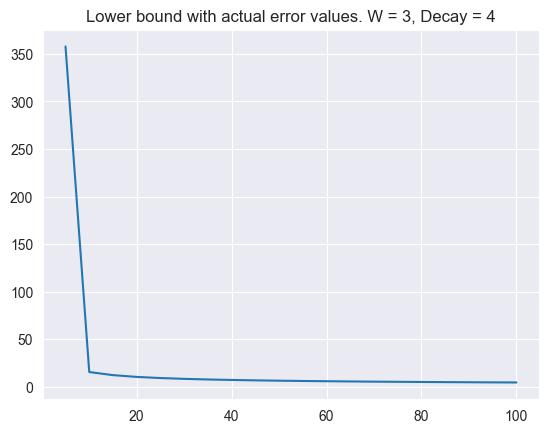

In [7]:
T = np.pi
shots = 1000
measurements = np.arange(5, 105, 5)
w = 3
decay = 4
w_bounds = []
a_bounds = []
for m in measurements:
    delay = np.linspace(0, T, m)
    Shots = len(delay) * [shots]
    fisher = fisher_matrix(delay, w, decay, Shots)
    w_bound, a_bound = lower_bound(fisher)
    w_bounds.append(100 * w_bound / w)
    a_bounds.append(100 * a_bound / decay)

plt.title(f'Lower bound with actual error values. W = {w}, Decay = {decay}')
from matplotlib import ticker

#plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.plot(measurements, w_bounds, label="w lower bound")
plt.errorbar(measurements, w_error, yerr=w_std, fmt='o', label='W')
# plt.plot(measurements, a_bounds, label="a lower bound", color="orange")
# plt.errorbar(measurements, decay_error, yerr=decay_std, fmt='o', label='Decay')
#plt.errorbar(measurements, j_error, yerr=j_std, fmt='o', label='J')
#plt.semilogy()
plt.ylim([0, 30])
plt.grid()
plt.legend()

In [309]:
from scipy.optimize import minimize


def find_optimal_times(W, A, N, Total_Shots=1000):
    def model_func(params):
        t = params[0:N]
        shots = params[N:2 * N]
        Iww = [0] * len(W)
        Iaa = [0] * len(W)
        Iwa = [0] * len(W)

        for i in range(len(t)):
            for j in range(len(W)):
                w = W[j]
                a = A[j]
                p0 = p(t[i], w, a)
                p1 = 1 - p0
                pw0 = pw(t[i], w, a)
                pw1 = -pw0
                pww0 = pww(t[i], w, a)
                pww1 = -pww0
                pa0 = pa(t[i], w, a)
                pa1 = -pa0
                paa0 = paa(t[i], w, a)
                paa1 = -paa0
                paw0 = paw(t[i], w, a)
                paw1 = -paw0

                if p0 == 0:
                    p0 = 1e-10
                if p1 == 0:
                    p1 = 1e-10

                Iww[j] -= shots[i] * (p0 * ((pww0 * p0 - pw0 ** 2) / p0 ** 2) + p1 * ((pww1 * p1 - pw1
                                                                                    ** 2) / p1 ** 2))
                Iaa[j] -= shots[i] * (p0 * ((paa0 * p0 - pa0 ** 2) / p0 ** 2) + p1 * ((paa1 * p1 - pa1 ** 2) / p1 ** 2))
                Iwa[j] -= shots[i] * (p0 * ((paw0 * p0 - pw0 * pa0) / p0 ** 2) + p1 * ((paw1 * p1 - pw1 * pa1) / p1 ** 2))

        lower_w_bound = np.sum([10000 * Iaa[j] / (Iaa[j] * Iww[j] - Iwa[j] ** 2) for j in range(len(W))])
        lower_a_bound = np.sum([10000 * Iww[j] / (Iaa[j] * Iww[j] - Iwa[j] ** 2) for j in range(len(W))])
        return lower_w_bound + lower_a_bound

    def shots_constraint(params):
        return np.sum(params[N:2 * N]) - Total_Shots

    # Define the constraint as a dictionary
    cons = ({'type': 'eq', 'fun': shots_constraint})
    initial_guess = np.concatenate([np.random.uniform(0, np.pi, N), np.full(N, Total_Shots / N)])
    result = minimize(model_func, initial_guess, method='trust-constr', bounds=[(0, np.pi)] * N + [(0, 1000)] * N,
                      constraints=cons)
    return result.x


def process_result(result):
    times = result[0:N]
    shots = result[N:2 * N]

    grouped_times = []
    grouped_shots = []

    for i in range(len(times)):
        for j in range(len(grouped_times)):
            if abs(grouped_times[j] - times[i]) < 0.005:
                #grouped_times.append(times[i])
                grouped_shots[j] += shots[i]
                break
        else:
            grouped_times.append(times[i])
            grouped_shots.append(shots[i])

    paired = sorted(zip(grouped_times, grouped_shots))
    times = [x for x, _ in paired]
    shots = [int(round(y)) for _, y in paired]

    return times, shots


N = 2
Total_Shots = N * 50
w = [3]
a = [3]
result = find_optimal_times(w, a, N, Total_Shots)
optimal_times, optimal_shots = process_result(result)

regular_times = np.linspace(0, np.pi, N)
print("Optimal times = ", optimal_times)
print("Optimal shots = ", optimal_shots)
fishers = [fisher_matrix(optimal_times, w[i], a[i], [1000]*N) for i in range(len(w))]
print("var = ", np.sum([np.trace(fishers[i]) for i in range(len(w))]))

Optimal times =  [0.14798027273025358, 0.5948984715023005]
Optimal shots =  [46, 54]
var =  23.547086629188925


In [306]:


#optimal_times, optimal_shots = process_result(result)
print("Optimal times = ", optimal_times)
print("Optimal shots = ", optimal_shots)
print(sum(optimal_shots))
optimal_w_bound = np.sum(lower_bound(fisher_matrix(optimal_times, w, a, optimal_shots)))
regular_w_bound = np.sum(lower_bound(fisher_matrix(regular_times, w, a, N * [100])))
print("Optimal w bound = ", optimal_w_bound)
print("Regular w bound = ", regular_w_bound)

Optimal times =  [0.14798026583825652, 0.5948984630908697]
Optimal shots =  [46, 54]
100


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [485]:
##approximation:
from scipy.optimize import minimize


def find_optimal_times_app(W, A, t):
    def model_func(t):
        Iww = [0] * len(W)
        Iaa = [0] * len(W)
        Iwa = [0] * len(W)

        for i in range(len(t)):
            for j in range(len(W)):
                w = W[j]
                a = A[j]
                Iww[j] += t[i]**2 * np.sin(w * t[i])**2 * np.exp(-2 * a * t[i])
                Iaa[j] += t[i]**2 * np.cos(w * t[i])**2 * np.exp(-2 * a * t[i])
                Iwa[j] += t[i]**2 * np.sin(w * t[i]) * np.cos(w * t[i]) * np.exp(-2 * a * t[i])




        lower_w_bound = np.sum([Iaa[j] / (0.001 if Iaa[j] * Iww[j] - Iwa[j] ** 2 == 0 else Iaa[j] * Iww[j] - Iwa[j] ** 2) for j in range(len(W))])
        lower_a_bound = np.sum([Iww[j] / (0.001 if Iaa[j] * Iww[j] - Iwa[j] ** 2 == 0 else Iaa[j] * Iww[j] - Iwa[j] ** 2) for j in range(len(W))])
        return lower_w_bound + lower_a_bound


    initial_guess = np.random.uniform(0.1, np.pi, t)
    result  = minimize(model_func, initial_guess,method='trust-constr', bounds=[(0, np.pi)] * t)
    return result.x


t = 4
w = [1,5]
a = [1,5]
optimal_times = find_optimal_times_app(w, a, t)

print("Optimal times = ", optimal_times)
fishers = [fisher_matrix(optimal_times, w[i], a[i], [1000]*t) for i in range(len(w))]
print("var = ", np.sum([t*np.trace(np.linalg.inv(fishers[i])) / (w[i]) for i in range(len(w)) ]))

Optimal times =  [0.12240649 1.09974928 0.382685   1.50257087]
var =  0.4790387064037642


In [111]:
from sympy import lambdify
## Normal approximation
from sympy import symbols, cos, sin, exp, sqrt
from scipy.optimize import minimize

# Define the symbols
t0, t1 = symbols('t0 t1', real=True, positive=True)

# Parameters
omega_value = gamma_value = w =a = 3

# Define the elements of the inverted matrix
I_00_expr = ((exp(2 * gamma_value * t1) * t0**2 * cos(omega_value * t0)**2 + exp(2 * gamma_value * t0) * t1**2 * cos(omega_value * t1)**2)
        * (1/sin(omega_value * (t0 - t1)))**2) / (t0**2 * t1**2)
I_11_expr = ((exp(2 * gamma_value * t1) * t0**2 * sin(omega_value * t0)**2 + exp(2 * gamma_value * t0) * t1**2 * sin(omega_value * t1)**2)
        * (1/sin(omega_value * (t0 - t1)))**2) / (t0**2 * t1**2)


# Define the function we want to find the minimum for
f_expr = sqrt(I_00_expr) + sqrt(I_11_expr)
#f_expr = sqrt(I_00_expr)
# Convert the symbolic expression to a numerical function
f_numeric = lambdify((t0, t1), f_expr, modules=['numpy'])

# Define a function to be minimized
def f_to_minimize(x):
    # x is a vector where x[0] = t0 and x[1] = t1
    return f_numeric(x[0], x[1])

# Initial guess (we avoid starting at 0 to prevent division by zero)
initial_guess = [0.1, 1]

# Perform the minimization
result = minimize(f_to_minimize, initial_guess, bounds=[(0.1, 5), (0.1, 5)])

# Extract the results
t0_min, t1_min = result.x
min_value = result.fun

print(t0_min, t1_min, min_value)
print("approximated_bound = ",np.sum(lower_bound(fisher_matrix([t0_min,t1_min], w, a, [2500,2500]))))



0.20331961151592476 0.6301486310494852 20.41778868091335
approximated_bound =  0.39112837679153956


In [1]:
from sympy import symbols, cos, sin, exp, csc, sqrt, diff, solve

# Define the symbols
t0, t1, omega, gamma = symbols('t0 t1 omega gamma', real=True, positive=True)

# Define the elements of the inverted matrix
I_00 = ((exp(-2 * gamma * t1) * t0**2 * cos(omega * t0)**2 + exp(-2 * gamma * t0) * t1**2 * cos(omega * t1)**2)
        * csc(omega * (t0 - t1))**2) / (t0**2 * t1**2)
I_11 = ((exp(-2 * gamma * t1) * t0**2 * sin(omega * t0)**2 + exp(-2 * gamma * t0) * t1**2 * sin(omega * t1)**2)
        * csc(omega * (t0 - t1))**2) / (t0**2 * t1**2)

# Define the function we want to minimize
f = sqrt(I_00) + sqrt(I_11)

# Compute the derivative of the function with respect to both t0 and t1
df_dt0 = diff(f, t0)
df_dt1 = diff(f, t1)

# Find the critical points by setting the derivatives to zero
critical_points = solve((df_dt0, df_dt1), (t0, t1))

critical_points



KeyboardInterrupt



In [232]:
VarA

1.0*(exp(a*t1) - cos(t1*w))*(exp(a*t1) + cos(t1*w))*(exp(a*t2) - cos(t2*w))*(exp(a*t2) + cos(t2*w))*(-t1**2*exp(2*a*t2)*sin(t1*w)**2 - t1**2*sin(t1*w)**2*sin(t2*w)**2 + t1**2*sin(t1*w)**2 - t2**2*exp(2*a*t1)*sin(t2*w)**2 - t2**2*sin(t1*w)**2*sin(t2*w)**2 + t2**2*sin(t2*w)**2)*exp(-a*t1 - a*t2 + 2*a*(t1 + t2))/(t1**2*(exp(a*t1) - cos(t1*w))**2*(exp(a*t1) + cos(t1*w))*(exp(a*t2) - cos(t2*w))**2*(exp(a*t2) + cos(t2*w))**2*exp(a*t2)*sin(t1*w)*cos(t1*w) + t1**2*(exp(a*t1) - cos(t1*w))*(exp(a*t1) + cos(t1*w))**2*(exp(a*t2) - cos(t2*w))**2*(exp(a*t2) + cos(t2*w))**2*exp(a*t2)*sin(t1*w)*cos(t1*w) + t2**2*(exp(a*t1) - cos(t1*w))**2*(exp(a*t1) + cos(t1*w))**2*(exp(a*t2) - cos(t2*w))**2*(exp(a*t2) + cos(t2*w))*exp(a*t1)*sin(t2*w)*cos(t2*w) + t2**2*(exp(a*t1) - cos(t1*w))**2*(exp(a*t1) + cos(t1*w))**2*(exp(a*t2) - cos(t2*w))*(exp(a*t2) + cos(t2*w))**2*exp(a*t1)*sin(t2*w)*cos(t2*w) - (t1**2*exp(2*a*t2)*cos(t1*w)**2 - t1**2*cos(t1*w)**2*cos(t2*w)**2 + t2**2*exp(2*a*t1)*cos(t2*w)**2 - t2**2*cos(t1*w)

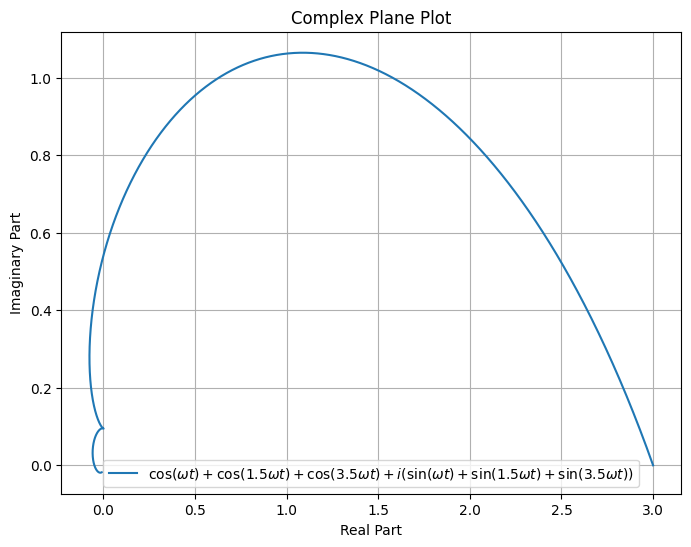

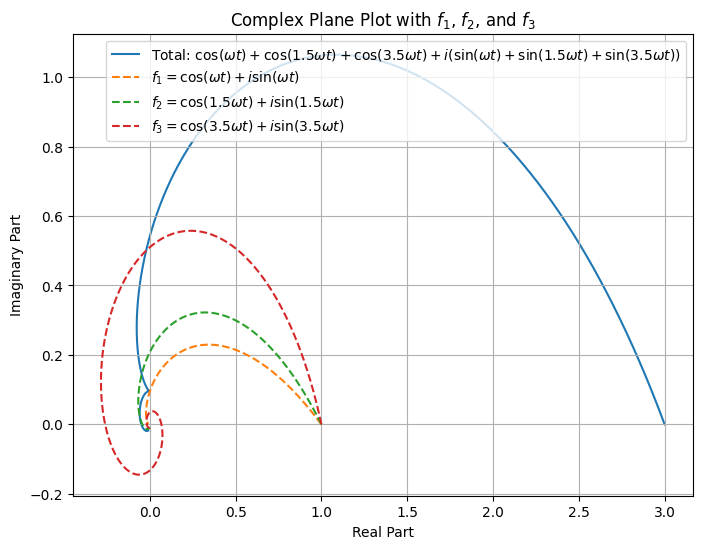

In [24]:
import numpy as np
import matplotlib.pyplot as plt
w=1
a = 1.5
t = np.linspace(0, 1*np.pi, 6000)  # time vector
# Defining f1, f2, f3
f1 = (np.cos(w*t) + 1j*np.sin(w*t)) * np.exp(-a*t)
f2 = (np.cos(1.5*w*t) + 1j*np.sin(1.5*w*t)) * np.exp(-a*t)
f3 = (np.cos(3.5*w*t) + 1j*np.sin(3.5*w*t)) * np.exp(-a*t)

# Updated Complex Function
real_part = (np.cos(w*t) + np.cos(1.5*w*t) + np.cos(3.5*w*t)) * np.exp(-a*t)
imaginary_part = (np.sin(w*t) + np.sin(1.5*w*t) + np.sin(3.5*w*t)) * np.exp(-a*t)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(real_part, imaginary_part, label=r'$\cos(\omega t) + \cos(1.5\omega t) + \cos(3.5\omega t) + i(\sin(\omega t) + \sin(1.5\omega t) + \sin(3.5\omega t))$')
plt.title('Complex Plane Plot')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.legend()
plt.grid(True)
plt.show()


# Updated Plot
plt.figure(figsize=(8, 6))
plt.plot(real_part, imaginary_part, label=r'Total: $\cos(\omega t) + \cos(1.5\omega t) + \cos(3.5\omega t) + i(\sin(\omega t) + \sin(1.5\omega t) + \sin(3.5\omega t))$', zorder=1)
plt.plot(f1.real, f1.imag, '--', label=r'$f_1 = \cos(\omega t) + i\sin(\omega t)$', zorder=2)
plt.plot(f2.real, f2.imag, '--', label=r'$f_2 = \cos(1.5\omega t) + i\sin(1.5\omega t)$', zorder=2)
plt.plot(f3.real, f3.imag, '--', label=r'$f_3 = \cos(3.5\omega t) + i\sin(3.5\omega t)$', zorder=2)
plt.title('Complex Plane Plot with $f_1$, $f_2$, and $f_3$')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.legend()
plt.grid(True)
plt.show()


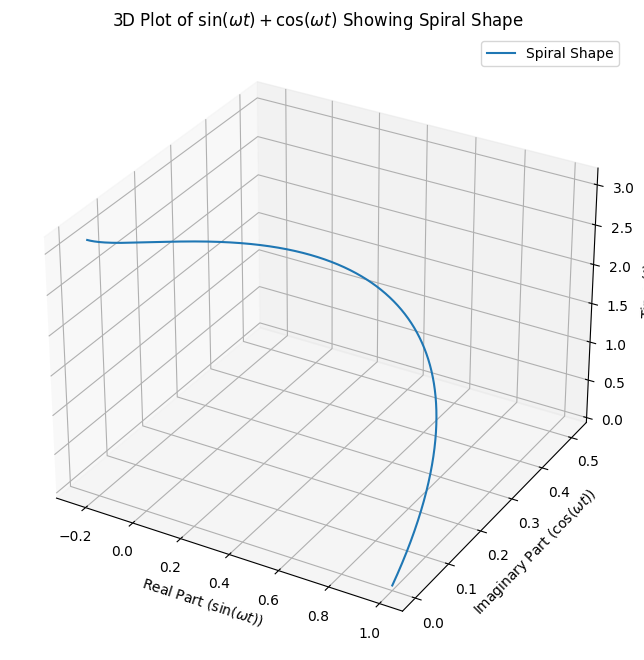

In [19]:
%matplotlib inline

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 3D Spiral
ax.plot(f1.real, f1.imag, t, label='Spiral Shape')
ax.set_title('3D Plot of $\sin(\omega t) + \cos(\omega t)$ Showing Spiral Shape')
ax.set_xlabel('Real Part ($\sin(\omega t)$)')
ax.set_ylabel('Imaginary Part ($\cos(\omega t)$)')
ax.set_zlabel('Time ($t$)')
ax.legend()

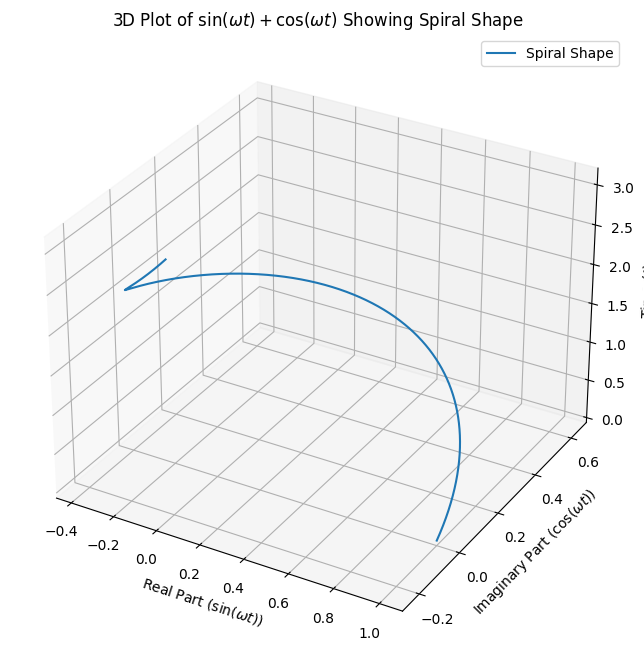

In [20]:
%matplotlib inline

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 3D Spiral
ax.plot(f2.real, f2.imag, t, label='Spiral Shape')
ax.set_title('3D Plot of $\sin(\omega t) + \cos(\omega t)$ Showing Spiral Shape')
ax.set_xlabel('Real Part ($\sin(\omega t)$)')
ax.set_ylabel('Imaginary Part ($\cos(\omega t)$)')
ax.set_zlabel('Time ($t$)')
ax.legend()

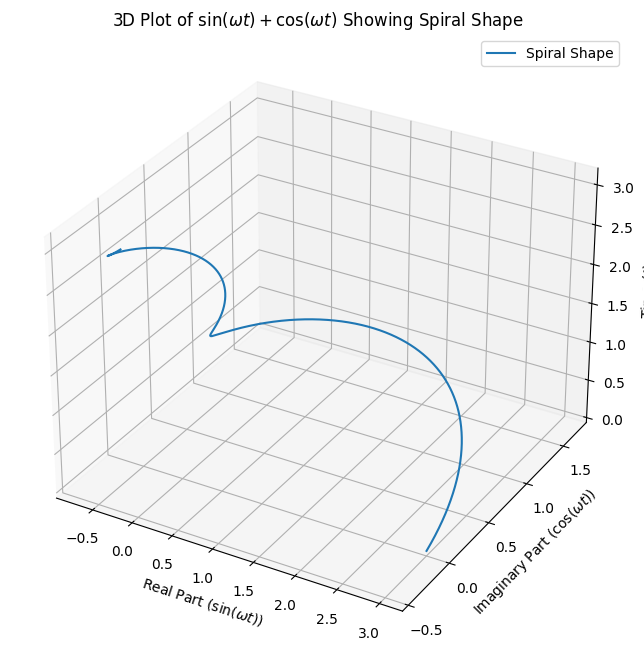

In [21]:
%matplotlib inline

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 3D Spiral
ax.plot(real_part, imaginary_part, t, label='Spiral Shape')
ax.set_title('3D Plot of $\sin(\omega t) + \cos(\omega t)$ Showing Spiral Shape')
ax.set_xlabel('Real Part ($\sin(\omega t)$)')
ax.set_ylabel('Imaginary Part ($\cos(\omega t)$)')
ax.set_zlabel('Time ($t$)')
ax.legend()